# Libraries

In [ ]:
# Standard Library Imports
import json
import os
from subprocess import check_output
from typing import Any, Optional, Tuple, Union

# Third-Party Library Imports
import albumentations as A
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import rasterio as rio
from affine import Affine
from matplotlib.colors import ListedColormap
from os.path import join
from pyproj import Transformer
from rasterio.plot import show_hist
from rasterio.transform import from_origin, rowcol, xy
from shapely.geometry import Polygon
from tqdm.autonotebook import tqdm
import torch
import rasterio
import richdem as rd
from urllib3 import Retry
from pystac_client.stac_api_io import StacApiIO
import seaborn as sns
import stackstac
from odc.stac import load
import xarray as xr
import rioxarray
from dask_gateway import GatewayCluster
import xrspatial.multispectral as ms
from dask.distributed import Client
import planetary_computer

# Third-Party Library Imports (Specific Modules)
from matplotlib import patches as patches
from rasterio.transform import from_origin
from torchvision.models.segmentation import (deeplabv3_resnet50,
                                             DeepLabV3_ResNet50_Weights)
                                            

# Local Project Imports
from rastervision.core.box import Box
from rastervision.core.data import (ClassConfig, GeoJSONVectorSourceConfig, GeoJSONVectorSource,
                                    MinMaxTransformer, MultiRasterSource,
                                    RasterioSource, RasterizedSourceConfig,
                                    RasterizedSource, Scene, StatsTransformer, ClassInferenceTransformer,
                                    VectorSourceConfig, VectorSource, XarraySource)
from rastervision.core.data.raster_source import XarraySource
from rastervision.core.data.raster_transformer import RasterTransformer
from rastervision.core.data.utils import (geoms_to_geojson, geojson_to_geoms,
                                          get_polygons_from_uris)
from rastervision.core.data.vector_source import sanitize_geojson
from rastervision.core.data import (CRSTransformer, IdentityCRSTransformer,
                                    RasterioCRSTransformer)
from rastervision.pipeline.file_system import make_dir
from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.pytorch_learner import (SemanticSegmentationGeoDataConfig,
                                          SemanticSegmentationLearner,
                                          SemanticSegmentationLearnerConfig,
                                          SemanticSegmentationRandomWindowGeoDataset,
                                          SemanticSegmentationSlidingWindowGeoDataset,
                                          SemanticSegmentationVisualizer, SolverConfig)
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50 
from torch.utils.data import DataLoader
from torch.multiprocessing import set_start_method
from torchgeo import models

# Set torch multiprocessing start method
set_start_method('fork', force=True)

# Set GDAL_DATA environment variable
os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()

In [ ]:
class CustomCRSTransformer(CRSTransformer):
    def __init__(self,
                 transform: Affine,
                 image_crs: Any,
                 map_crs: Any = 'epsg:4326',
                 round_pixels: bool = True):

        if (image_crs is None) or (image_crs == map_crs):
            self.map2image = lambda *args, **kws: args[:2]
            self.image2map = lambda *args, **kws: args[:2]
        else:
            self.map2image = Transformer.from_crs(
                map_crs, image_crs, always_xy=True).transform
            self.image2map = Transformer.from_crs(
                image_crs, map_crs, always_xy=True).transform

        self.round_pixels = round_pixels

        super().__init__(transform, image_crs, map_crs)

    def __repr__(self) -> str:
        cls_name = type(self).__name__

        image_crs_str = str(self.image_crs)
        if len(image_crs_str) > 70:
            image_crs_str = image_crs_str[:70] + '...'

        map_crs_str = str(self.map_crs)
        if len(map_crs_str) > 70:
            map_crs_str = map_crs_str[:70] + '...'

        transform_str = (
            '\n\t\t' + (str(self.transform).replace('\n', '\n\t\t')))
        out = f"""{cls_name}(
            image_crs="{image_crs_str}",
            map_crs="{map_crs_str}",
            round_pixels="{self.round_pixels}",
            transform={transform_str})
        """
        return out

    def _map_to_pixel(self, map_point):
        image_point = self.map2image(*map_point)
        x, y = image_point
        if self.round_pixels:
            row, col = rowcol(self.transform, x, y)
        else:
            row, col = rowcol(self.transform, x, y, op=lambda x: x)
        pixel_point = (col, row)
        return pixel_point

    def _pixel_to_map(self, pixel_point):
        col, row = pixel_point
        if self.round_pixels:
            col = col.astype(int) if isinstance(col, np.ndarray) else int(col)
            row = row.astype(int) if isinstance(row, np.ndarray) else int(row)
        image_point = xy(self.transform, row, col, offset='center')
        map_point = self.image2map(*image_point)
        return map_point
    
    ### ADPATING THIS BIT ###
    @classmethod
    def from_affine_transfrom(
            cls, predefined_transform: Any, map_crs: Optional[str] = 'epsg:4326', image_crs='epsg:4326', **kwargs
    ) -> Union[IdentityCRSTransformer, 'CustomCRSTransformer']:
        transform = predefined_transform
        map_crs = image_crs if map_crs is None else map_crs
        # image_crs = map_crs

        no_crs_tf = (image_crs is None) or (image_crs == map_crs)
        no_affine_tf = (transform is None) or (transform == Affine.identity())
        if no_crs_tf and no_affine_tf:
            return IdentityCRSTransformer()

        if transform is None:
            transform = Affine.identity()

        return cls(transform, image_crs, map_crs, **kwargs)
    
# Helper functions
def plot_geoms(geoms: list, title=''):
    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == 'Polygon':
            xy = np.array(g.exterior.coords)
            patch = patches.Polygon(xy, color='#55cc77', alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor='#005511', fill=None, alpha=1)
            ax.add_patch(patch)
        elif g.geom_type == 'LineString':
            xy = np.array(g.buffer(1).exterior.coords)
            patch = patches.Polygon(xy, color='#005511', alpha=0.8)
            ax.add_patch(patch)
        else:
            raise NotImplementedError()
    ax.set_title(title, fontsize=14)
    ax.autoscale()
    plt.show()

In [ ]:
from typing import TYPE_CHECKING, Any, List, Optional, Sequence, Tuple, Union
import logging

import numpy as np
from xarray import DataArray

from rastervision.core.box import Box
from rastervision.core.data.crs_transformer import RasterioCRSTransformer
from rastervision.core.data.raster_source import RasterSource
from rastervision.core.data.utils import parse_array_slices_Nd, fill_overflow

if TYPE_CHECKING:
    from pystac import Item, ItemCollection
    from rastervision.core.data import RasterTransformer, CRSTransformer

log = logging.getLogger(__name__)

class XarraySource(RasterSource):
    """A RasterSource for reading an Xarry DataArray.

    .. warning:: ``XarraySource`` API is in beta.
    """

    def __init__(self,
                 data_array: DataArray,
                 crs_transformer: 'CRSTransformer',
                 raster_transformers: List['RasterTransformer'] = [],
                 channel_order: Optional[Sequence[int]] = None,
                 bbox: Optional[Box] = None,
                 temporal: bool = False):

        self.temporal = temporal
        if self.temporal:
            if set(data_array.dims) != {'x', 'y', 'band', 'time'}:
                raise ValueError(
                    'If temporal=True, data_array must have 4 dimensions: '
                    '"x", "y", "band", and "time" (in any order).')
        else:
            if set(data_array.dims) != {'x', 'y', 'band'}:
                raise ValueError(
                    'If temporal=False, data_array must have 3 dimensions: '
                    '"x", "y", and "band" (in any order).')

        self.data_array = data_array.transpose(..., 'y', 'x', 'band')
        self.ndim = data_array.ndim
        self._crs_transformer = crs_transformer

        num_channels_raw = len(data_array.band)
        if channel_order is None:
            channel_order = np.arange(num_channels_raw, dtype=int)
        else:
            channel_order = np.array(channel_order, dtype=int)
        self._num_channels = None
        self._dtype = None
        if len(raster_transformers) == 0:
            self._num_channels = len(channel_order)
            self._dtype = data_array.dtype

        height, width = len(data_array.y), len(data_array.x)
        self.full_extent = Box(0, 0, height, width)
        if bbox is None:
            bbox = self.full_extent
        else:
            if bbox not in self.full_extent:
                new_bbox = bbox.intersection(self.full_extent)
                log.warning(f'Clipping ({bbox}) to the DataArray\'s '
                            f'full extent ({self.full_extent}). '
                            f'New bbox={new_bbox}')
                bbox = new_bbox

        super().__init__(
            channel_order,
            num_channels_raw,
            raster_transformers=raster_transformers,
            bbox=bbox)

    @classmethod
    def from_stac(
            cls,
            item_or_item_collection: Union['Item', 'ItemCollection'],
            raster_transformers: List['RasterTransformer'] = [],
            channel_order: Optional[Sequence[int]] = None,
            bbox: Optional[Box] = None,
            bbox_map_coords: Optional[Box] = None,
            temporal: bool = False,
            allow_streaming: bool = False,
            stackstac_args: dict = dict(rescale=False)) -> 'XarraySource':
        """Construct an ``XarraySource`` from a STAC Item or ItemCollection.

        Args:
            item_or_item_collection: STAC Item or ItemCollection.
            raster_transformers: RasterTransformers to use to transform chips
                after they are read.
            channel_order: List of indices of channels to extract from raw
                imagery. Can be a subset of the available channels. If None,
                all channels available in the image will be read.
                Defaults to None.
            bbox: User-specified crop of the extent. If None, the full extent
                available in the source file is used. Mutually exclusive with
                ``bbox_map_coords``. Defaults to ``None``.
            bbox_map_coords: User-specified bbox in EPSG:4326 coords of the
                form (ymin, xmin, ymax, xmax). Useful for cropping the raster
                source so that only part of the raster is read from. Mutually
                exclusive with ``bbox``. Defaults to ``None``.
            temporal: If True, data_array is expected to have a "time"
                dimension and the chips returned will be of shape (T, H, W, C).
            allow_streaming: If False, load the entire DataArray into memory.
                Defaults to True.
            stackstac_args: Optional arguments to pass to stackstac.stack().
        """
        import stackstac

        data_array = stackstac.stack(item_or_item_collection, **stackstac_args)

        if not temporal and 'time' in data_array.dims:
            if len(data_array.time) > 1:
                raise ValueError('temporal=False but len(data_array.time) > 1')
            data_array = data_array.isel(time=0)

        if not allow_streaming:
            from humanize import naturalsize
            log.info('Loading the full DataArray into memory '
                     f'({naturalsize(data_array.nbytes)}).')
            data_array.load()

        crs_transformer = RasterioCRSTransformer(
            transform=data_array.transform, image_crs=data_array.crs)

        if bbox is not None:
            if bbox_map_coords is not None:
                raise ValueError('Specify either bbox or bbox_map_coords, '
                                 'but not both.')
            bbox = Box(*bbox)
        elif bbox_map_coords is not None:
            bbox_map_coords = Box(*bbox_map_coords)
            bbox = crs_transformer.map_to_pixel(bbox_map_coords).normalize()
        else:
            bbox = None

        raster_source = XarraySource(
            data_array,
            crs_transformer=crs_transformer,
            raster_transformers=raster_transformers,
            channel_order=channel_order,
            bbox=bbox,
            temporal=temporal)
        return raster_source

    @property
    def shape(self) -> Tuple[int, int, int]:
        """Shape of the raster as a (height, width, num_channels) tuple."""
        H, W = self.bbox.size
        if self.temporal:
            T = len(self.data_array.time)
            return T, H, W, self.num_channels
        return H, W, self.num_channels

    @property
    def num_channels(self) -> int:

        if self._num_channels is None:
            self._set_info_from_chip()
        return self._num_channels

    @property
    def dtype(self) -> np.dtype:
        if self._dtype is None:
            self._set_info_from_chip()
        return self._dtype

    @property
    def crs_transformer(self) -> RasterioCRSTransformer:
        return self._crs_transformer

    def _set_info_from_chip(self):
        """Read 1x1 chip to get info not statically inferable."""
        test_chip = self.get_chip(Box(0, 0, 1, 1))
        self._dtype = test_chip.dtype
        self._num_channels = test_chip.shape[-1]

    def _get_chip(self,
                  window: Box,
                  bands: Union[int, Sequence[int], slice] = slice(None),
                  time: Union[int, Sequence[int], slice] = slice(None),
                  out_shape: Optional[Tuple[int, ...]] = None) -> np.ndarray:
        window = window.to_global_coords(self.bbox)

        window_within_bbox = window.intersection(self.bbox)

        yslice, xslice = window_within_bbox.to_slices()
        if self.temporal:
            chip = self.data_array.isel(
                x=xslice, y=yslice, band=bands, time=time).to_numpy()
        else:
            chip = self.data_array.isel(
                x=xslice, y=yslice, band=bands).to_numpy()

        if window != window_within_bbox:
            *batch_dims, h, w, c = chip.shape
            # coords of window_within_bbox within window
            yslice, xslice = window_within_bbox.to_local_coords(
                window).to_slices()
            tmp = np.zeros((*batch_dims, *window.size, c))
            tmp[..., yslice, xslice, :] = chip
            chip = tmp

        chip = fill_overflow(self.bbox, window, chip)
        if out_shape is not None:
            chip = self.resize(chip, out_shape)
        return chip

    def get_chip(self,
                 window: Box,
                 bands: Optional[Union[int, Sequence[int], slice]] = None,
                 time: Union[int, Sequence[int], slice] = slice(None),
                 out_shape: Optional[Tuple[int, ...]] = None) -> np.ndarray:
        """Read a chip specified by a window from the file.

        Args:
            window (Box): Bounding box of chip in pixel coordinates.
            bands (Optional[Union[Sequence[int], slice]], optional): Subset of
                bands to read. Note that this will be applied on top of the
                channel_order (if specified). So if this is an RGB image and
                channel_order=[2, 1, 0], then using bands=[0] will return the
                B-channel. Defaults to None.
            out_shape (Optional[Tuple[int, ...]], optional): (height, width) of
                the output chip. If None, no resizing is done.
                Defaults to None.

        Returns:
            np.ndarray: A chip of shape (height, width, channels).
        """
        if bands is None or bands == slice(None):
            bands = self.channel_order
        else:
            bands = self.channel_order[bands]
        chip = self._get_chip(
            window, bands=bands, time=time, out_shape=out_shape)
        for transformer in self.raster_transformers:
            chip = transformer.transform(chip, bands)
        return chip

    def __getitem__(self, key: Any) -> 'np.ndarray':
        if isinstance(key, Box):
            return self.get_chip(key)

        window, dim_slices = parse_array_slices_Nd(
            key, extent=self.extent, dims=self.ndim)
        if self.temporal:
            t, h, w, c = dim_slices
        else:
            h, w, c = dim_slices
            t = None

        out_shape = None
        if h.step is not None or w.step is not None:
            out_h, out_w = window.size
            if h.step is not None:
                out_h //= h.step
            if w.step is not None:
                out_w //= w.step
            out_shape = (int(out_h), int(out_w))

        chip = self.get_chip(window, bands=c, time=t, out_shape=out_shape)
        return chip
    
    def calculate_ndbi(chip, nir_band=3, swir_band=4):
        nir = chip[:, :, nir_band]  # NIR band
        swir = chip[:, :, swir_band]  # SWIR band
        ndbi = (swir - nir) / (swir + nir)

        return ndbi
    
    def patched_get_chip(self, window: Box, bands=None, time=slice(None), out_shape=None):
        chip = self._get_chip(window, bands=bands, time=time, out_shape=out_shape)

        # Compute NDBI if NIR and SWIR bands are present
        if 3 in bands and 4 in bands:  # Assuming NIR is at index 3 and SWIR is at index 4
            ndbi = calculate_ndbi(chip)
            # Add NDBI as the fifth channel
            ndbi = np.expand_dims(ndbi, axis=2)
            chip_with_ndbi = np.concatenate((chip, ndbi), axis=2)
            return chip_with_ndbi

        return chip

In [ ]:
class CustomMinMaxTransformer(RasterTransformer):
    """Transforms chips by scaling values in each channel to span a specified range."""

    def __init__(self, min_val: Union[float, List[float]], max_val: Union[float, List[float]]):
        """
        Args:
            min_val: Minimum value(s) for scaling. If a single value is provided, it will be broadcasted
                across all channels. If a list of values is provided, it should match the number of channels.
            max_val: Maximum value(s) for scaling. Same broadcasting rules as min_val apply.
        """
        self.min_val = min_val
        self.max_val = max_val

    def transform(self,
                  chip: np.ndarray,
                  channel_order: Optional[List[int]] = None) -> np.ndarray:
        c = chip.shape[-1]
        pixels = chip.reshape(-1, c)
        
        # Broadcasting if single value provided
        if isinstance(self.min_val, (int, float)):
            channel_mins = np.array([self.min_val] * c)
        else:
            channel_mins = np.array(self.min_val)
        
        if isinstance(self.max_val, (int, float)):
            channel_maxs = np.array([self.max_val] * c)
        else:
            channel_maxs = np.array(self.max_val)
        
        chip_normalized = (chip - channel_mins) / (channel_maxs - channel_mins)
        chip_normalized = np.clip(chip_normalized, 0, 1)  # Clip values to [0, 1] range
        chip_normalized = (255 * chip_normalized).astype(np.uint8)
        return chip_normalized

# Vector Source

In [ ]:
# Manually define the affine transformation matrix
label_uri = '../data/0/overture/santodomingo.parquet'
gdf = gpd.read_parquet(label_uri)
print(gdf.crs)
xmin, ymin, xmax, ymax = gdf.total_bounds
scale_factor = 0.000009462403025800147 #  roughly 1 metre for lat 18
translate_x = xmin  
translate_y = ymin 
affine_transform = Affine(scale_factor, 0, translate_x,
                          0, -scale_factor, translate_y)
print("Created affine transform: ", affine_transform)

{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal component of 3D system.", "area": "World.", "bb

In [ ]:
label_uri = '../data/0/overture/santodomingo.geojson'

crs_transformer = CustomCRSTransformer.from_affine_transfrom(
    affine_transform, map_crs='epsg:4326',
    image_crs='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    vector_transformers=[ClassInferenceTransformer(default_class_id=1)])

rasterized_source = RasterizedSource(
    vector_source,
    background_class_id=0)

Transforming to pixel coords:   5%|5         | 50147/961511 [00:05<01:30, 10029.36it/s]

Splitting multi-part geoms:  48%|####8     | 462779/961511 [00:05<00:05, 92555.63it/s]

Simplifying polygons:   9%|8         | 86244/961524 [00:05<00:50, 17248.68it/s]

Splitting multi-part geoms:  45%|####4     | 428307/961524 [00:05<00:06, 85661.21it/s]

# Reading Labels

In [ ]:
SD_infset = gpd.read_file('../data/0/UNITAC_data/SantoDomingo_PS_modified.geojson')
SD_infset = SD_infset.to_crs('EPSG:4326')

SD_infset = SD_infset.unary_union
SD_infset = SD_infset.simplify(tolerance=0.0001, preserve_topology=True)
SD_infset_gs = gpd.GeoSeries([SD_infset])
# SD_infset_gs.to_file('../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson', driver='GeoJSON')

gdf = gpd.read_file("../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson")
xmin, ymin, xmax, ymax = gdf.total_bounds
scale_factor = 0.000009462403025800147 #  roughly 1 metre for lat 18
translate_x = xmin  
translate_y = ymin
affine_transform_labels = Affine(scale_factor, 0, translate_x,
                          0, -scale_factor, translate_y)
print("Created affine transform: ", affine_transform_labels)

# m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=12)
# SD_infset_json = SD_infset_gs.to_json()
# folium.GeoJson(
#     SD_infset_json,
#     name='Slums'
# ).add_to(m)

# folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', name='satellite', attr='Esri').add_to(m)

# folium.LayerControl().add_to(m)
# m

Created affine transform:  | 0.00, 0.00,-70.00|
| 0.00,-0.00, 18.43|
| 0.00, 0.00, 1.00|


In [ ]:
img_uri = '../data/1/UNITAC_data/SantoDomingo_PS.tif'
label_uri = '../data/1/UNITAC_data/SantoDomingo_PS.geojson'

crs_transformer_11 = RasterioCRSTransformer.from_uri(img_uri)
crs_transformer_11

RasterioCRSTransformer(
            image_crs="GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER...",
            map_crs="epsg:4326",
            round_pixels="True",
            transform=
		| 0.00, 0.00,-70.00|
		| 0.00,-0.00, 18.54|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
crs_transformer_labels = CustomCRSTransformer.from_affine_transfrom(
    affine_transform_labels, map_crs='epsg:4326',
    image_crs='GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,3],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1]],USAGE[SCOPE["Geodesy. Navigation and positioning using GPS satellite system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4979]]')

crs_transformer_labels

CustomCRSTransformer(
            image_crs="GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER...",
            map_crs="epsg:4326",
            round_pixels="True",
            transform=
		| 0.00, 0.00,-70.00|
		| 0.00,-0.00, 18.43|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
class_config = ClassConfig(names=['background', 'slums'], 
                           colors=['lightgray', 'darkred'],
                           null_class='background')

label_vector_source = GeoJSONVectorSource(
    '../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson',
    crs_transformer_labels,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('slums'))])

label_raster_source = RasterizedSource(
    label_vector_source,
    background_class_id=class_config.null_class_id)

In [ ]:
from rastervision.core.data import SemanticSegmentationLabelSource

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config)

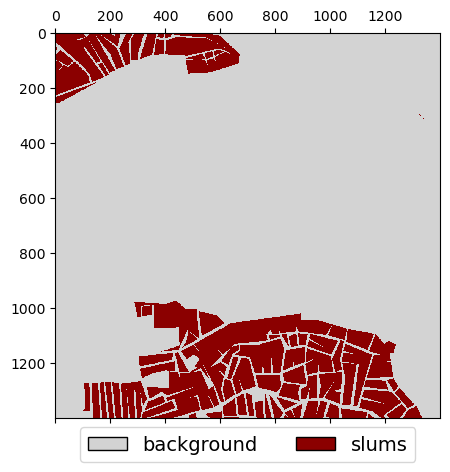

In [ ]:
label_chip = label_source[1000:2400, 1000:2400]

fig, ax = plt.subplots(figsize=(5, 5))
cmap = ListedColormap(class_config.color_triples)
ax.matshow(label_chip, cmap=cmap)

legend_items = [
    patches.Patch(facecolor=cmap(i), edgecolor='black', label=cname)
    for i, cname in enumerate(class_config.names)]
ax.legend(
    handles=legend_items,
    ncol=len(class_config),
    loc='upper center',
    fontsize=14,
    bbox_to_anchor=(0.5, 0))
plt.show()

# Raster Source

## Sentinel

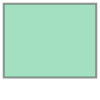

In [ ]:
### SENTINEL source directly from Earth Search
bounds = gdf.total_bounds
geom = Polygon([
    (bounds[0], bounds[1]),
    (bounds[2], bounds[1]),
    (bounds[2], bounds[3]),
    (bounds[0], bounds[3]),
    (bounds[0], bounds[1])
])
BANDS = [
    'coastal', # B01
    'blue', # B02
    'green', # B03
    'red', # B04
    'rededge1', # B05
    'rededge2', # B06
    'rededge3', # B07
    'nir', # B08
    'nir08', # B8A
    'nir09', # B09
    'swir16', # B11
    'swir22', # B12
]

In [ ]:
# client = Client()
# print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

In [125]:
# Search
retry = Retry(total=5, backoff_factor=1, status_forcelist=[502, 503, 504], allowed_methods=None)
stac_api_io = StacApiIO(max_retries=retry)

EARTH_SEARCH_ENDPOINT = 'https://earth-search.aws.element84.com/v1'
EARTH_SEARCH_COLLECTION = "sentinel-2-c1-l2a"

client = pystac_client.Client.open(EARTH_SEARCH_ENDPOINT, stac_io=stac_api_io, modifier=planetary_computer.sign_inplace)

search = client.search(
    collections=[EARTH_SEARCH_COLLECTION],
    intersects=geom,
    datetime='2022-01-01/2024-05-17',
    limit=100,
    query={'eo:cloud_cover': {'lt': 7}}
)
if search.matched() == 0:
    print("No available data for specified time!")
    items = None
else:
    items = search.get_all_items()
    print("Found {} available S2 acquisition dates.".format(search.matched()))

data_array = stackstac.stack(items, assets=BANDS, rescale=False, fill_value=0, bounds_latlon=bounds, dtype=np.uint8)
datamosaicked = stackstac.mosaic(data_array, dim="time", nodata=0)
crs_transformer_sentinel = RasterioCRSTransformer(transform=datamosaicked.transform, image_crs='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

print(data_array.shape)
print(datamosaicked.shape)

Found 6 available S2 acquisition dates.
(6, 12, 1292, 1544)
(12, 1292, 1544)


In [126]:
# MOSAICKING
def flatten(x, dim="time"):
    assert isinstance(x, xr.DataArray)
    if len(x[dim].values) > len(set(x[dim].values)):
        x = x.groupby(dim).map(stackstac.mosaic)
    return x

sentinel_stack = data_array.assign_coords(time=data_array.time.astype("datetime64[D]"))
flat_stack = flatten(sentinel_stack, dim="time")
flat_stack = flat_stack.compute()
flat_stack.shape

In [ ]:
stac_json = search.item_collection_as_dict()
jsons = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
jsons.explore(fill=False)

In [ ]:
import odc
xx = odc.stac.load(
    search.get_items(),
    bands=["red", "green", "blue"],
    resolution=100,
)
xx.red.plot.imshow(col="time")

In [ ]:
raster_source_unnormalized = XarraySource(
    data_array,
    temporal=True,
    crs_transformer=crs_transformer_sentinel,
    channel_order = [3,2,1,7,10] # R,G,B + NIR + SWIR
)

stats_tf = StatsTransformer.from_raster_sources([raster_source_unnormalized])

Analyzing chips: 0it [00:00, ?it/s]

In [ ]:
sentinel_source = XarraySource(
    datamosaicked,
    raster_transformers=[stats_tf],
    crs_transformer=crs_transformer_sentinel,
    channel_order = [3,2,1,7,10] # R,G,B + NIR + SWIR
)
sentinel_source.shape

(1292, 1544, 5)

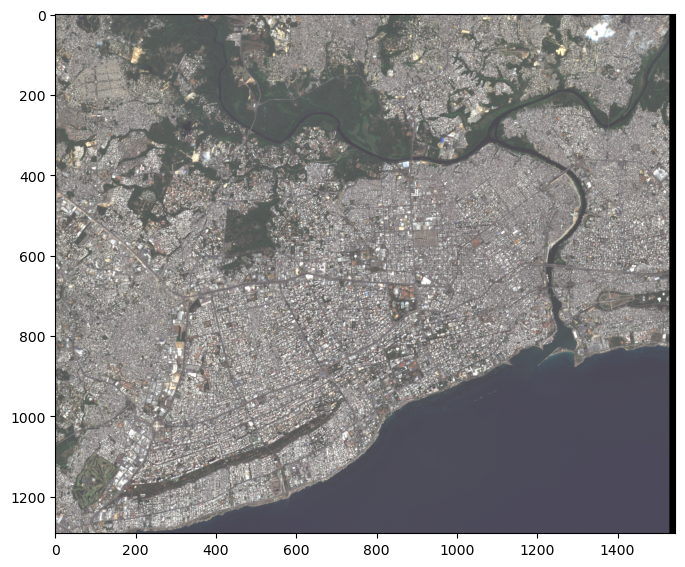

In [ ]:
chip = sentinel_source[:, :, [0,1,2]]
chip.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(chip)
plt.show()

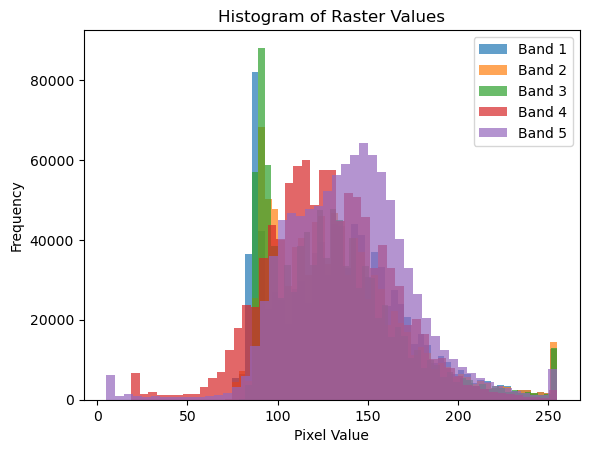

In [ ]:
chip = sentinel_source[:1000, :1000, :]  # Assuming it's a 5-channel image
for band_idx in range(chip.shape[2]):
    band = chip[:, :, band_idx]
    flat_band = band.flatten()
    plt.hist(flat_band, bins=50, alpha=0.7, label=f'Band {band_idx+1}')
plt.title('Histogram of Raster Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
data = (
    stackstac.stack(
        items,
        bounds_latlon=bounds,
        assets=BANDS,  # red, green, blue, NIR, SWIR
        # chunksize=4096, # when using Dask
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

crs_transformer_sent = RasterioCRSTransformer(transform=data.transform, image_crs='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

data.shape
datamosaicked = stackstac.mosaic(data, dim="time", axis=None, nodata=0).squeeze()
datamosaicked.shape

(7, 12, 2790, 6039)

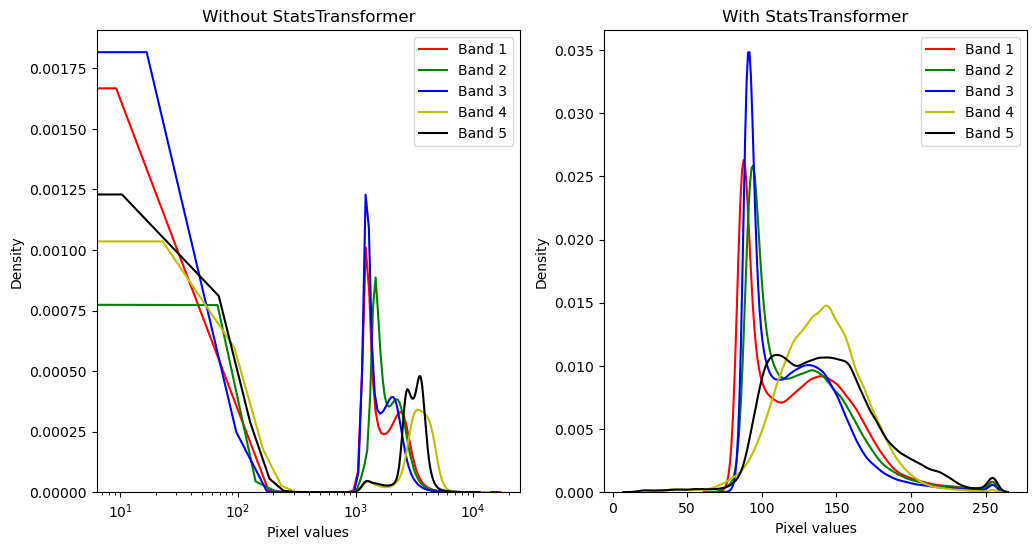

In [ ]:
chip_normalized = sentinel_source[:400, :400]
band_colors = ['r', 'g', 'b', 'y', 'black']  # Define colors for each band
chip_unnormalized = raster_source_unnormalized[:400, :400]

fig, (ax_l, ax_r) = plt.subplots(1, 2, squeeze=True, figsize=(12, 6))

# left
for i in range(chip_unnormalized.shape[-1]):
    sns.kdeplot(chip_unnormalized[..., i].flat, ax=ax_l, color=band_colors[i], label=f'Band {i+1}')
ax_l.set_xscale('log')
ax_l.set_xlabel('Pixel values')
ax_l.legend()
ax_l.set_title('Without StatsTransformer')

# right
for i in range(chip_normalized.shape[-1]):
    sns.kdeplot(chip_normalized[..., i].flat, ax=ax_r, color=band_colors[i], label=f'Band {i+1}')
ax_r.set_xlabel('Pixel values')
ax_r.legend()
ax_r.set_title('With StatsTransformer')

plt.show()

## DEM data

In [ ]:
# dem_uri = '../data/0/SD-DEM.tif'
# with rasterio.open(dem_uri) as src:
#     dem_data = src.read(1)

# filtered_dem_data = np.where((dem_data >= -10) & (dem_data <= 50), dem_data, np.nan)
# plt.figure(figsize=(10, 5))
# show_hist(filtered_dem_data, bins=70, title='Histogram of Filtered DEM Raster Values')
# plt.show()

In [ ]:
# SD_dem = rd.LoadGDAL(dem_uri)

# #save slope GeoTif
# slope = rd.TerrainAttribute(SD_dem, attrib='slope_riserun')
# rd.SaveGDAL('../data/0/SD-DEM_slope.tif', slope)

# # show slope
# rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
# plt.show()

In [ ]:
# slope_uri = ['../data/0/SD-DEM_slope.tif']

# slope_source = RasterioSource(slope_uri, allow_streaming=True)#, raster_transformers=[MinMaxTransformer()])

# slope_stats_transformer = StatsTransformer.from_raster_sources(
#     raster_sources=[slope_source],
#     max_stds=3)

# slope_source_normalized = RasterioSource(
#     slope_uri,
#     allow_streaming=True,
#     raster_transformers=[slope_stats_transformer])
    

# print(slope_source_normalized.shape)
# print(slope_source_normalized.dtype)

# chip = slope_source_normalized[:898, :2054]

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(chip)
# plt.show()

## Planet Imagery source

In [ ]:
# from rastervision.core.data import RasterioSource

# planet_uris = ['../data/0/Planet/SD_mosaic-0000000000-0000000000.tif',
#                '../data/0/Planet/SD_mosaic-0000000000-0000023296.tif',
#                '../data/0/Planet/SD_mosaic-0000000000-0000046592.tif',
#                '../data/0/Planet/SD_mosaic-0000023296-0000000000.tif',
#                '../data/0/Planet/SD_mosaic-0000023296-0000023296.tif',
#                '../data/0/Planet/SD_mosaic-0000023296-0000046592.tif']

# planet_source = RasterioSource(planet_uris, allow_streaming=True,
#                                raster_transformers=[CustomMinMaxTransformer(min_val=64, max_val=5454)],
#                                channel_order=[2, 1, 0, 3])

# # planet_stats_transformer = StatsTransformer.from_raster_sources(
# #     raster_sources=[planet_source],
# #     max_stds=3)

# # planet_source_normalized = RasterioSource(
# #     planet_uri,
# #     allow_streaming=True,
# #     raster_transformers=[planet_stats_transformer])

# print(planet_source.shape)
# print(planet_source.dtype)
# planet_source.crs_transformer.image_crs

In [ ]:
# chip = planet_source[10000:20000, 10000:20000]

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(chip)
# plt.show()

# MultiRaster source

In [ ]:
sentinel_source.crs_transformer

RasterioCRSTransformer(
            image_crs="GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.2572235...",
            map_crs="epsg:4326",
            round_pixels="True",
            transform=
		| 10.00, 0.00, 394500.00|
		| 0.00,-10.00, 2050490.00|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
rasterized_source.crs_transformer

CustomCRSTransformer(
            image_crs="GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.2572235...",
            map_crs="epsg:4326",
            round_pixels="True",
            transform=
		| 0.00, 0.00,-70.16|
		| 0.00,-0.00, 18.37|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
raster_source_multi = MultiRasterSource(raster_sources=[rasterized_source, sentinel_source], primary_source_idx=1) #planet_source, slope_source_normalized
raster_source_multi.shape, raster_source_multi.dtype

((1292, 1544, 6), dtype('uint8'))

In [ ]:
# chip = raster_source_multi[7000:18500, 15000:35000]
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.matshow(chip[..., 0])
# plt.show()

In [ ]:
rasterized_source.dtype

numpy.uint8

In [ ]:
sentinel_source.dtype

dtype('uint8')

In [ ]:
chip = raster_source_multi[200:1200, 300:1400]

KeyboardInterrupt: 

In [ ]:
fig, (ax_buil, ax_rgb, ax_nir_ir) = plt.subplots(1, 3, figsize=(15, 3))

ax_buil.matshow(chip[..., 0])
ax_buil.set_title('Buildings')

ax_rgb.matshow(chip[..., 1:4])
ax_rgb.set_title('RGB')

ax_nir_ir.matshow(chip[..., 5])
ax_nir_ir.set_title('NIR IR')

plt.show()

MemoryError: Unable to allocate 1.07 EiB for an array with shape (1056814001, 1162495401) and data type uint8

(3000, 3000, 6)


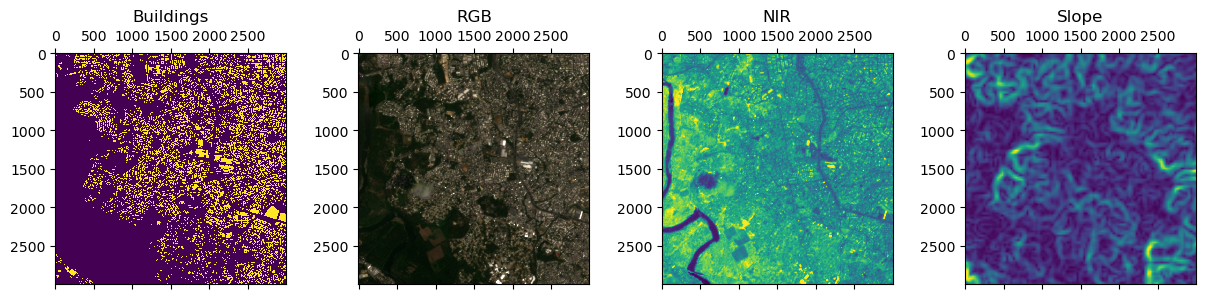

In [ ]:
# chip = raster_source_multi[15000:18000, 15000:18000]
# print(chip.shape)

# fig, (ax_buil, ax_rgb, ax_nir, ax_slope) = plt.subplots(1, 4, figsize=(15, 3))

# ax_buil.matshow(chip[..., 0])
# ax_buil.set_title('Buildings')

# ax_rgb.matshow(chip[..., 1:4])
# ax_rgb.set_title('RGB')

# ax_nir.matshow(chip[..., 4:5])
# ax_nir.set_title('NIR')

# ax_slope.matshow(chip[..., 5:6])
# ax_slope.set_title('Slope')

# plt.show()

In [ ]:
def show_windows(img, windows, title=''):
    from matplotlib import pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(8, 8))
    ax.imshow(img)
    ax.axis('off')
    for w in windows:
        p = patches.Polygon(w.to_points(), color='r', linewidth=1, fill=False)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()

# Scene

In [ ]:
train_aoi_polygon = Polygon.from_bounds(xmin=15000, ymin=-7000, xmax=35000, ymax=-18500)
val_aoi_polygon = Polygon.from_bounds(xmin=15000, ymin=-18500, xmax=24000, ymax=-21500)

train_scene = Scene(
    id='santo_domingo_train',
    raster_source=raster_source_multi,
    label_source=label_source,
    aoi_polygons=[train_aoi_polygon])

val_scene = Scene(
    id='santo_domingo_val',
    raster_source=raster_source_multi,
    label_source=label_source,
    aoi_polygons=[val_aoi_polygon])

220


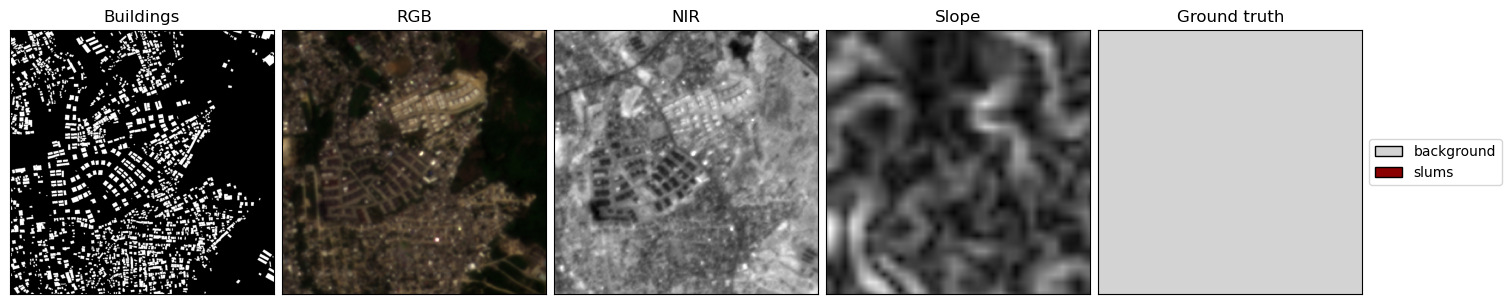

In [ ]:
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene=train_scene,
    size=1000,
    stride=1000,
    out_size=1000,
    within_aoi=True,
)
print(len(ds))

x, y = ds[13]
channel_display_groups = {'Buildings': [0], 'RGB': [1,2,3], 'NIR': [4],'Slope': [5]}

vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups)

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

# Training

In [ ]:
device = torch.device('mps')
batch_size = 8
lr = 1e-4
epochs = 5
output_dir = '../lightning-demo/'
make_dir(output_dir)
fast_dev_run = False

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        # A.HueSaturationValue(hue_shift_limit=10),
        # A.RGBShift(),
        # A.ToGray(),
        # A.ToSepia(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

# Define datasets
train_ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene=train_scene,
    size=256,
    stride=128,
    out_size=256,
    transform=data_augmentation_transform,
    within_aoi=True
)

val_ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene=val_scene,
    size=256,
    stride=128,
    out_size=256,
    within_aoi=True
)
print(f"Train dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
x, y = train_ds[42]
vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

NameError: name 'train_scene' is not defined

In [ ]:
# Define DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4)

class SemanticSegmentation(pl.LightningModule):
    def __init__(self, deeplab, lr=1e-4):
        super().__init__()
        self.deeplab = deeplab
        self.lr = lr

        self.deeplab.backbone.conv1 = torch.nn.Conv2d(
            6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )

    def forward(self, img):
        return self.deeplab(img)['out']

    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = F.cross_entropy(out, mask)
        log_dict = {'train_loss': loss}
        self.log_dict(log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = F.cross_entropy(out, mask)
        log_dict = {'validation_loss': loss}
        self.log_dict(log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr)
        return optimizer
    
deeplab = deeplabv3_resnet50(num_classes=len(class_config) + 1)
model = SemanticSegmentation(deeplab, lr=lr)
tb_logger = TensorBoardLogger(save_dir=output_dir, flush_secs=10)
trainer = pl.Trainer(
    accelerator='auto',
    min_epochs=1,
    max_epochs=epochs+1,
    default_root_dir=output_dir,
    logger=[tb_logger],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
models.ResNet50_Weights

<enum 'ResNet50_Weights'>

In [ ]:
# %reload_ext tensorboard
# %tensorboard --bind_all --logdir "../lightning-demo/lightning_logs" --reload_interval 10

In [ ]:
trainer.fit(model, train_dl, val_dl)


  | Name    | Type      | Params
--------------------------------------
0 | deeplab | DeepLabV3 | 39.6 M
--------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.575   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x178915580>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rastervision/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/miniconda3/envs/rastervision/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/miniconda3/envs/rastervision/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/rastervision/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/rastervision/lib/python3.12/multiprocessing/connection.py", line 1135, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^

In [ ]:
from torch import nn
from typing import Sequence

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
    
class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: Sequence[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)

class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels: int, num_classes: int, aspp_out_channels: int, atrous_rates: Sequence[int] = (12, 24, 36)) -> None:
        super().__init__(
            ASPP(in_channels, atrous_rates, out_channels=aspp_out_channels),
            nn.Conv2d(aspp_out_channels, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
            nn.Softmax(dim=1)
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output shape: torch.Size([8, 2, 128, 128])
(128, 128, 3)
torch.Size([3, 128, 128])


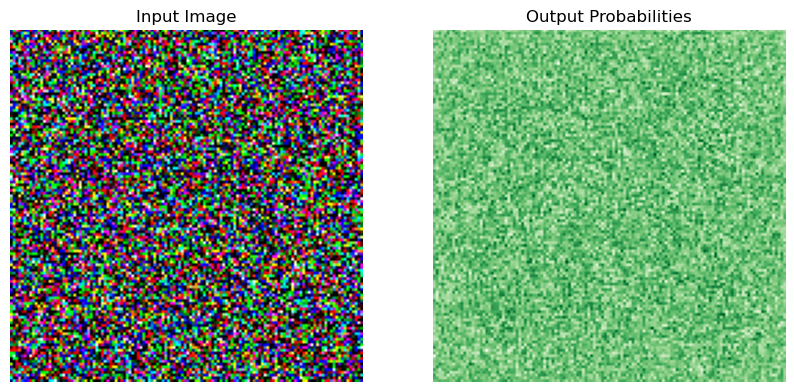

In [ ]:
deeplab_head = DeepLabHead(in_channels=6, num_classes=2, atrous_rates=[6, 12, 18], aspp_out_channels=128)
input_data = torch.randn(8, 6, 128, 128)

# Pass input data through the DeepLabHead
output = deeplab_head(input_data)

# Print the shape of the output
print("Output shape:", output.shape)

# Convert input and output data to numpy arrays for visualization
input_image = input_data[0, :3, :, :].permute(1, 2, 0).numpy()
output_probs = output[0].detach().numpy()  # Convert output to numpy array

# Visualize input and output images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Output Probabilities')
for i in range(output_probs.shape[0]):
    plt.imshow(output_probs[i], alpha=1, cmap='Greens')
plt.axis('off')

plt.show()

In [ ]:
# model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet50', num_classes=len(class_config),in_channels=4,out_size=(256, 256))
# data_cfg = SemanticSegmentationGeoDataConfig(
#     class_config=class_config,
#     num_workers=0)

# solver_cfg = SolverConfig(
#     batch_sz=16,
#     lr=3e-2,
#     class_loss_weights=[1., 10.]
# )
# learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [ ]:
# learner = SemanticSegmentationLearner(
#     cfg=learner_cfg,
#     output_dir='../train-demo/',
#     model=model,
#     train_ds=train_ds,
#     valid_ds=val_ds
# )
# learner.log_data_stats()

In [ ]:
# learner.train(epochs=50)

In [ ]:
# learner.plot_predictions(split='valid', show=True)